# IBM Streams HBASE sample application
This sample demonstrates creating a Streams Python application to connect to HBASE, perform some operations on a table, and viewing the results.

In this notebook, you'll see examples of how to:
- [Setup](#setup)
- [Create HBASE credentials](#credentials)
- [Create the application](#create)
- [Submit the application](#submit)
- [Connect to the running application to view data](#view)

# Overview
**About the sample**

This application simulates data tuples that are inserted into a HBASE table and get all rows from the table.

**How it works**
   
The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to retrieve the results.

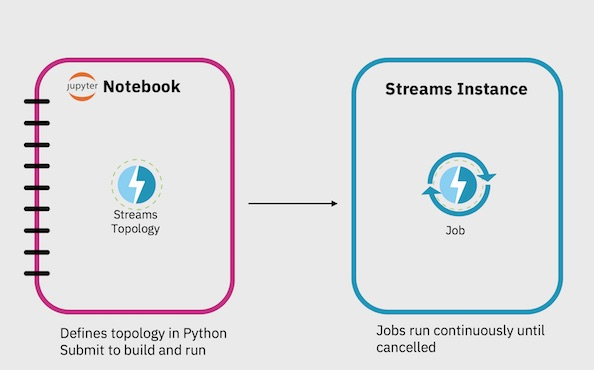


### Documentation
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



## <a name="setup"> </a> 1. Setup



### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

### 1.2 Import  the `streamsx.hbase` package and verify the package version

In [ ]:
import streamsx.hbase as hb
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.hbase package version: " + hb.__version__)

### <a name="credentials"> </a> 1.3 Configure the connection to HBASE

Perform the steps [Connecting to data source](https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_current/cpd/access/connect-data-sources.html) 
and create an external configuration for your HBASE connection.

1. Select as connection type "HDFS-HDP"
2. Enter HDFS "host" and "port"
3. Set the field "WebHDFSUrl" to None since it is not required for HBASE. 

Update the name in the cell below according to your connection name.

In [ ]:
connection_name = 'HBASE'

In [ ]:
hbase_connection=icpd_util.get_connection(connection_name, conn_class='external')
print (hbase_connection)

## <a name="create"> </a> 2. Create the application
All Streams applications start with a Topology object, so start by creating one:


In [ ]:
#Imports
from streamsx.topology.topology import *
from streamsx.topology.context import *
from streamsx.topology.schema import StreamSchema
import streamsx.hbase as hbase
import json


# create a Topology object
topo = Topology(name="hbase", namespace="sample")


### How to use the streamsx.hbase package

The streamsx.hbase package is the Python wrapper for the [streamsx.hbase](https://ibmstreams.github.io/streamsx.hbase/doc/spldoc/html) toolkit

Python package documentation: http://streamsxhbase.readthedocs.io/

## <a name="download"> </a> 2.2. Download the latest version of streamsx.hbase toolkit
If you want to work with the latest version of streamsx.hbase toolkit, it is possible to download the toolkit and add the hbase toolkit location to your topology. <br/>
The list of releases of streamsx.hdfs are in github: <br/>
    "https://github.com/IBMStreams/streamsx.hbase/releases"


In [ ]:
#hbase_toolkit_location = hbase.download_toolkit()
#streamsx.spl.toolkit.add_toolkit(topo, hbase_toolkit_location)

## <a name="insert"> </a> 2.3. Insert streaming data into the table

Next, we generate a stream of data and insert it into the table we created.<br/>
But befor we start the application, we have to create an HBASE test table on our hadoop server.<br/>
The table name is in our test is: `streamsSample_lotr` (lord of the rings). <br/>
Login to the hadoop server and start the hbase shell tool and create a table. <br/>
```
hbase shell
create 'streamsSample_lotr','appearance','location'
```  

In [ ]:
table_name = 'streamsSample_lotr'

In the first step we put some rows into HBASE table. <br/>
The function `_create_stream_for_put` creates a stream that contains 10 rows. <br/> 
The function `hbase.put` gets the streams `putStream` as input and inserts created rows into HBASE Table.

In [ ]:
def _create_stream_for_put(topo):
    putStream = topo.source([0,1,2,3,4,5,6,7,8,9])
    schema=StreamSchema('tuple<int32 id, rstring character, rstring colF, rstring colQ, rstring value, int64 Timestamp>').as_tuple()
    return putStream.map(lambda x : (x,'Gandalf_' + str(x), 'location','beginTwoTowers', 'travelling'), schema=schema)

putStream = _create_stream_for_put(topo) 
put_rows = hbase.put(putStream, table_name=table_name, connection=hbase_connection)
put_rows.print()

## <a name="get"> </a> 2.4. get data from the table
Now we get rows from the table. <br/>
The function `_create_query_stream_for_get` creates a stream that contains queries. <br/>
The function `hbase.get` gets `getStrem` as input stream and returns selected rows. <br/>
The parameter `row_attr_name` specifies the name of the attribute on the input tuple containing the columnFamily.

In [ ]:
def _create_query_stream_for_get(topo):
    getStream = topo.source([0,1,2,3,4,5,6,7,8,9])
    schema=StreamSchema('tuple<int32 id, rstring who, rstring infoType, rstring requestedDetail>').as_tuple()
    return getStream.map(lambda x : (x,'Gandalf_' + str(x), 'location','beginTwoTowers'), schema=schema)

getStream = _create_query_stream_for_get(topo) 
get_rows = hbase.get(getStream, table_name=table_name, row_attr_name="who", connection=hbase_connection, name="HbaseGet")
get_rows.print()

## <a name="scan"> </a> 2.5. scan all rows from the table
In the next step we scan all rows from the table.<br/>
The function `hbase.scan` returns all rows from the HBASE table.<br/>
This parameter `init_delay` specifies the time to wait in seconds before the operator scans the rows. <br/>
This parameter `max_versions` specifies the maximum number of versions that the operator returns. It defaults to a value of one. A value of 0 indicates that the operator gets all versions. 

In [ ]:
scanned_rows = hbase.scan(topo, table_name=table_name, max_versions=0 , init_delay=10, connection=hbase_connection, name="HbaseScan")
scanned_rows.print()


# create a view to check retrieving rows from a table
scannedView = scanned_rows.view(name="scannedRows", description="scanned rows from HBASE table")

# <a name="submit"> </a> 3. Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# submit the topology 'topo'
submission_result = context.submit ("DISTRIBUTED", topo, config = cfg)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)

# <a name="view"> </a> 4. View data from the table
Now that the job is started, use the View object you have already created to start retrieving rows from a HBASE table.

In [ ]:
# Connect to the view and display the selected data
queue = scannedView.start_data_fetch()
try:
    for val in range(5):
        print(queue.get(timeout=60))    
finally:
    scannedView.stop_data_fetch()

# <a name="status"> </a> 5. See job status

You can view job status and logs by going to Projects > Jobs. Find your job based on the name printed above. Retrieve job logs using the "Download logs" action from the job's context menu.

To view other information about the job such as detailed metrics, access the graph. Go to **Projects** > **Jobs**. Select "View graph" action for the running job.


# <a name="cancel"></a> 6. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.


In [ ]:
# cancel the job directly using the Job object
streams_job.cancel()

## Summary
In this sample we created an HBASE application which connects to the Hadoop server, insetrted some rows into HBASE table and get the rows from the table.

After submitting the application to the Streams service, we checked the application logs to see the progress.

It is also possible to check the contents of the test table on the HBASE server with the following `hbase shell` command.

```
hbase shell
scan 'streamsSample_lotr'
```
  

